In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=""

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=""


In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
module_path = os.path.abspath(os.path.join('../src'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = ""

In [3]:
from src import train, generate, eval
#from runfiles import train, generate, eval
from modules.config import read_config
import modules.plots as plots
from modules.datageneration import load_data, data_functions
from src.pipeline_util import load_bnn
from src.train import make_inference_model
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import os
import pyro
import pyro.poutine as poutine


from torch.utils.data import random_split, TensorDataset
from torch.utils.data.dataloader import DataLoader

import dill
import multiprocessing

/Home/siv31/tak011/.conda/envs/master/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
BASE_DIR = "../tests/sanity_check"
PROFILE = "tyxe-test"

#BASE_DIR = "./tests/x-dim-test"
#PROFILE = "test"

In [5]:
[torch.cuda.device(i) for i in range(torch.cuda.device_count())]

[]

In [6]:
multiprocessing.cpu_count()

256

In [7]:
configs = read_config(f"{BASE_DIR}/config.ini")
dataset_configs = read_config(f"{BASE_DIR}/dataset_config.ini")

config = configs[PROFILE]
NAME = config["NAME"]
dataset_config = dataset_configs[config["DATASET"]]
DATASET_NAME = dataset_config["NAME"]

In [8]:
config["DEVICE"] = "cpu"#config["DEVICE"]
config["INFERENCE_TYPE"] = "mcmc"

config["MCMC_NUM_SAMPLES"] = "50"
config["MCMC_NUM_WARMUP"] = "20"
config["MCMC_NUM_CHAINS"] = "2"
config["RERUNS"] = "1"

dataset_config["TRAIN_SIZE"] = "100"
dataset_config["TEST_SIZE"] = "100"
dataset_config["SIGMA"] = "0.3"

====== Generating profile sin-(10,20)-10k ======
Train: (-10, 10)
Y-space: -1.4279431423488806 - 1.5602615588548145
In Domain: (-10, 10)
Y-space: -1.5728629001484995 - 1.5151104079718951
Out Domain: (-20, 20)
Y-space: -1.5110794057988066 - 1.4468968173085783


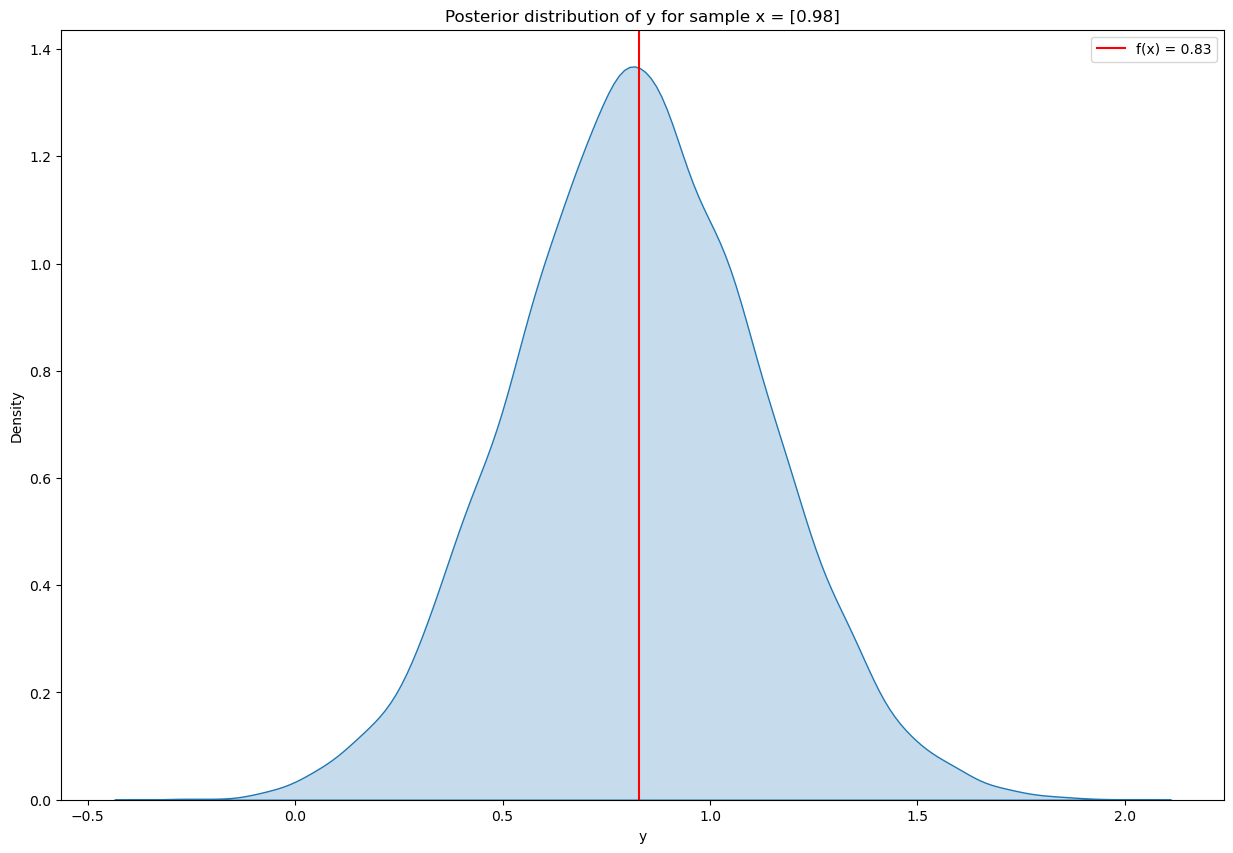

In [9]:
if True:
    if not os.path.exists(f"{BASE_DIR}/datasets"):
                os.mkdir(f"{BASE_DIR}/datasets")
    generate.gen(dataset_config, f"{BASE_DIR}/datasets")

In [10]:
(x_train, y_train), _, (x_test_in_domain, y_test_in_domain), (x_test_out_domain, y_test_out_domain) = load_data(f"{BASE_DIR}/datasets/{DATASET_NAME}", load_val=False)
x_test, y_test = torch.vstack((x_test_in_domain, x_test_out_domain)), torch.vstack((y_test_in_domain, y_test_out_domain))

In [11]:
x_train.shape, y_train.shape

(torch.Size([100, 1]), torch.Size([100, 1]))

In [12]:
train_dataset = TensorDataset(x_train, y_train)

train_dataloader = DataLoader(train_dataset, batch_size=128)

In [13]:
x, y = next(iter(train_dataloader))

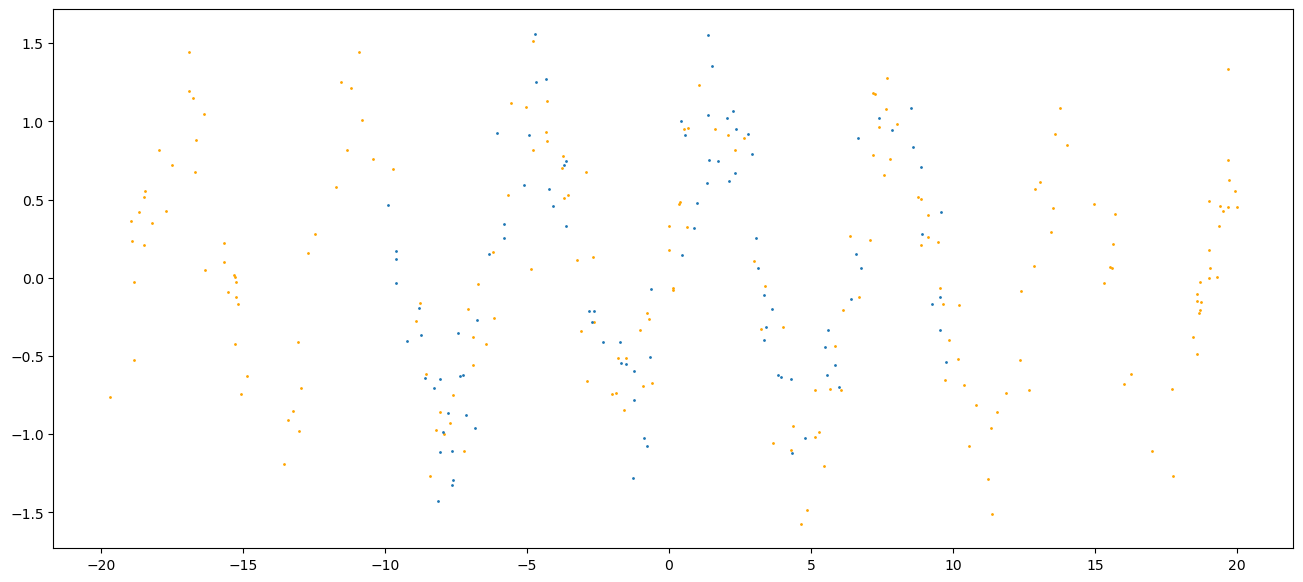

In [14]:
test_sort = torch.argsort(x_test.squeeze())
fig, ax = plt.subplots(figsize=(16, 7))
plt.scatter(x_test[test_sort].squeeze(), y_test[test_sort], color="orange", s=1)
plt.scatter(x_train.squeeze(), y_train, s=1)


In [15]:
pyro.clear_param_store()

if True:
    if not os.path.exists(f"{BASE_DIR}/models"):
                os.mkdir(f"{BASE_DIR}/models")
    if not os.path.exists(f"{BASE_DIR}/results"):
                os.mkdir(f"{BASE_DIR}/results")
    train.train(config, dataset_config, f"{BASE_DIR}", reruns=config.getint("RERUNS"), device=config["DEVICE"], num_workers=1)

Cuda Devices: []
torch.Size([100, 1]) torch.Size([100, 1])
Settings:
DEVICE: cpu INFERENCE_TYPE: mcmc OBS_MODEL: homoskedastic PRIOR_LOC: 0.0 PRIOR_SCALE: 1.0 LIKELIHOOD_SCALE_LOC: 1.0 LIKELIHOOD_SCALE: 0.3 GUIDE_SCALE: 0.001 TRAIN_SIZE: 100
Using device: cpu
===== Training profile tyxe-test - 1 =====


Warmup [2]:   0%|          | 0/70 [00:00, ?it/s]/Home/siv31/tak011/.conda/envs/master/lib/python3.9/site-packages/pyro/poutine/subsample_messenger.py:63: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  result = torch.tensor(0.0, device=self.device)
/Home/siv31/tak011/.conda/envs/master/lib/python3.9/site-packages/pyro/poutine/subsample_messenger.py:63: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  result = torch.tensor(0.0, device=self.device)


Warmup [1]:   1%|▏         | 1/70 [00:00,  2.72it/s, step size=1.40e-02, acc. prob=1.000]


{'net.0.weight': tensor([[-1.3148],
        [-0.0882],
        [ 1.4379],
        [-0.1894],
        [ 0.0617],
        [-0.1810],
        [ 0.4017],
        [ 1.2751],
        [ 1.9045],
        [ 1.2719],
        [ 1.8935],
        [-0.1591],
        [-1.8168],
        [-0.9433],
        [ 1.3549],
        [-0.0121],
        [-0.9754],
        [-1.5451],
        [-1.8745],
        [-1.6805],
        [-0.4065],
        [ 1.0902],
        [ 1.0720],
        [-1.9115],
        [ 1.2480],
        [-1.5478],
        [-0.4300],
        [-0.8048],
        [-0.3907],
        [-0.3939],
        [-1.8058],
        [-1.7211]]), 'net.0.bias': tensor([-1.1629,  0.6815, -1.1890, -0.0469,  0.0846,  1.2899, -1.5119, -1.3706,
        -1.1598,  1.4014, -0.7200,  1.6865,  0.7236,  0.2531, -0.0177, -0.3937,
         0.2506, -0.4534, -0.0134,  0.2529, -1.5646, -1.0499,  1.6136, -1.6259,
        -0.1414,  1.9768,  0.7223,  0.0556, -1.7320,  0.9905, -1.4229, -0.5690]), 'net.2.weight': tensor([[-1.1621,  1

Warmup [2]:   1%|▏         | 1/70 [00:00,  2.61it/s, step size=2.81e-02, acc. prob=1.000]

File Size is 0.00041103363037109375 MB
{'net.0.weight': tensor([[ 1.6522],
        [ 1.2532],
        [ 1.2847],
        [ 1.3511],
        [ 1.2457],
        [ 0.5631],
        [-1.1601],
        [-1.8150],
        [-0.6247],
        [-0.3981],
        [-1.1043],
        [ 0.7063],
        [ 0.6003],
        [-0.2140],
        [ 0.7945],
        [ 0.6700],
        [ 1.2865],
        [ 1.3490],
        [-0.7661],
        [ 1.9424],
        [-0.2579],
        [-0.0641],
        [-1.5850],
        [-1.1485],
        [-1.2149],
        [-0.9479],
        [ 1.4873],
        [-0.3951],
        [-1.4803],
        [ 0.7533],
        [ 0.6359],
        [ 1.3392]]), 'net.0.bias': tensor([ 0.9217,  1.2653,  1.9743, -1.4213,  0.4866, -1.4756,  1.6730, -0.7541,
         1.1536,  0.0891, -0.1731, -0.0691,  0.3330,  0.9026,  0.3194,  0.6236,
        -1.7845,  1.4555,  1.7631,  1.6589,  1.4872, -1.4433, -0.7805,  1.7443,
        -1.5145,  1.8227, -1.5624, -1.4465,  0.9778, -1.4399, -0.4607,  1.4647])

Warmup [1]:   7%|▋         | 5/70 [00:00, 12.81it/s, step size=4.95e-04, acc. prob=0.600]



{'net.0.weight': tensor([[-1.3303],
        [-0.0619],
        [ 1.4535],
        [-0.1731],
        [ 0.0716],
        [-0.1964],
        [ 0.3944],
        [ 1.2823],
        [ 1.9308],
        [ 1.2775],
        [ 1.8785],
        [-0.1838],
        [-1.8328],
        [-0.9447],
        [ 1.3359],
        [-0.0137],
        [-0.9614],
        [-1.5554],
        [-1.8734],
        [-1.6755],
        [-0.4046],
        [ 1.0696],
        [ 1.0444],
        [-1.8984],
        [ 1.2520],
        [-1.5351],
        [-0.4340],
        [-0.8048],
        [-0.3917],
        [-0.3920],
        [-1.8162],
        [-1.7159]]), 'net.0.bias': tensor([-1.1654,  0.6839, -1.1844, -0.0538,  0.0904,  1.2880, -1.5134, -1.3686,
        -1.1539,  1.4061, -0.7257,  1.6840,  0.7266,  0.2541, -0.0211, -0.3942,
         0.2462, -0.4584, -0.0119,  0.2508, -1.5647, -1.0505,  1.6086, -1.6297,
        -0.1409,  1.9767,  0.7242,  0.0530, -1.7327,  0.9909, -1.4248, -0.5699]), 'net.2.weight': tensor([[-1.1693,  


Warmup [2]:   6%|▌         | 4/70 [00:00,  8.77it/s, step size=6.33e-04, acc. prob=0.500]

{'net.0.weight': tensor([[ 1.6760],
        [ 1.2774],
        [ 1.2659],
        [ 1.3797],
        [ 1.2554],
        [ 0.5447],
        [-1.1865],
        [-1.7598],
        [-0.6818],
        [-0.3541],
        [-1.1208],
        [ 0.7138],
        [ 0.6078],
        [-0.2667],
        [ 0.7832],
        [ 0.6590],
        [ 1.2574],
        [ 1.3504],
        [-0.7306],
        [ 1.9437],
        [-0.2409],
        [-0.0647],
        [-1.6342],
        [-1.1626],
        [-1.1908],
        [-0.9074],
        [ 1.4580],
        [-0.4475],
        [-1.4585],
        [ 0.7580],
        [ 0.6397],
        [ 1.3212]]), 'net.0.bias': tensor([ 0.9228,  1.2685,  1.9701, -1.4192,  0.4838, -1.4766,  1.6780, -0.7582,
         1.1641,  0.0791, -0.1731, -0.0703,  0.3368,  0.9099,  0.3165,  0.6200,
        -1.7866,  1.4538,  1.7586,  1.6566,  1.4834, -1.4423, -0.7777,  1.7468,
        -1.5182,  1.8177, -1.5676, -1.4415,  0.9740, -1.4404, -0.4600,  1.4614]), 'net.2.weight': tensor([[ 1.7712,  1.


Warmup [2]:   9%|▊         | 6/70 [00:00, 10.35it/s, step size=1.68e-03, acc. prob=0.667]

{'net.0.weight': tensor([[ 1.7178],
        [ 1.3391],
        [ 1.2389],
        [ 1.4647],
        [ 1.2690],
        [ 0.4626],
        [-1.2250],
        [-1.8126],
        [-0.6664],
        [-0.3794],
        [-1.0732],
        [ 0.7054],
        [ 0.6051],
        [-0.4035],
        [ 0.7959],
        [ 0.6342],
        [ 1.1995],
        [ 1.3709],
        [-0.6786],
        [ 1.9698],
        [-0.0818],
        [-0.1068],
        [-1.6258],
        [-1.1740],
        [-1.1917],
        [-0.8791],
        [ 1.4387],
        [-0.4989],
        [-1.4499],
        [ 0.7208],
        [ 0.6839],
        [ 1.3091]]), 'net.0.bias': tensor([ 0.8365,  1.1603,  2.1205, -1.5570,  0.4482, -1.3848,  1.6975, -0.7104,
         1.1245,  0.1232, -0.1626, -0.0783,  0.2882,  0.8198,  0.3775,  0.6846,
        -1.6963,  1.4616,  1.7797,  1.6171,  1.5677, -1.4465, -0.7820,  1.7417,
        -1.5329,  1.8128, -1.5100, -1.4784,  0.9916, -1.4531, -0.4026,  1.5415]), 'net.2.weight': tensor([[ 1.7120,  1.


Warmup [2]:  11%|█▏        | 8/70 [00:01,  6.14it/s, step size=2.50e-03, acc. prob=0.718]

{'net.0.weight': tensor([[ 1.7478],
        [ 0.7714],
        [ 0.5989],
        [ 1.7786],
        [ 1.6146],
        [ 0.9811],
        [-1.0156],
        [-1.9155],
        [ 0.7310],
        [-0.6087],
        [-0.8467],
        [ 0.8768],
        [ 0.7971],
        [-0.3044],
        [ 1.1126],
        [ 0.6943],
        [ 1.1720],
        [ 1.1971],
        [-0.9255],
        [ 2.0966],
        [-0.1183],
        [ 0.1182],
        [-1.5280],
        [-0.9599],
        [-0.7931],
        [-1.2849],
        [ 1.7105],
        [-1.6485],
        [-1.7736],
        [ 0.7564],
        [ 0.8950],
        [ 1.6304]]), 'net.0.bias': tensor([ 0.5851,  1.2593,  2.7233, -1.5911,  0.2521, -0.8699,  1.9790, -1.1910,
         1.5222,  0.0718, -0.1177, -0.1867,  0.0345,  1.4407,  0.3178,  0.6800,
        -1.5369,  1.0680,  1.7877,  1.8158,  1.5740, -1.4819, -0.5789,  1.7049,
        -1.7487,  1.8215, -0.9018, -0.9361,  0.9651, -1.1930, -0.4739,  1.6869]), 'net.2.weight': tensor([[ 1.4072,  1.

Warmup [1]:  11%|█▏        | 8/70 [00:01,  5.42it/s, step size=7.25e-04, acc. prob=0.697]


{'net.0.weight': tensor([[-1.1669],
        [-0.4175],
        [ 1.4051],
        [-0.2184],
        [ 0.2445],
        [-0.7220],
        [ 0.8874],
        [ 1.2341],
        [ 1.9495],
        [ 1.5198],
        [ 1.9139],
        [-0.8748],
        [-1.7669],
        [-0.9453],
        [ 1.2792],
        [-0.0187],
        [-1.0680],
        [-1.7159],
        [-1.9258],
        [-1.6651],
        [-0.3410],
        [ 1.2934],
        [ 0.6626],
        [-2.0251],
        [ 1.3033],
        [-1.4639],
        [-0.5027],
        [-0.7590],
        [-0.4962],
        [-0.6588],
        [-1.6452],
        [-1.7090]]), 'net.0.bias': tensor([-1.0582,  0.7662, -1.1563, -0.1353,  0.1049,  1.1420, -1.3858, -1.3634,
        -1.0172,  1.4685, -1.0689,  1.2445,  0.9610,  0.2624, -0.0986, -0.4619,
         0.0599, -0.2533,  0.1310,  0.0949, -1.6589, -1.2101,  1.5509, -1.8745,
        -0.0661,  1.8403,  0.6557, -0.0162, -1.7672,  0.8823, -1.2221, -0.7024]), 'net.2.weight': tensor([[-1.0555e+00


Warmup [2]:  14%|█▍        | 10/70 [00:02,  2.80it/s, step size=6.06e-04, acc. prob=0.690]


{'net.0.weight': tensor([[ 1.8277],
        [ 1.2685],
        [ 0.8566],
        [ 1.5663],
        [ 1.6835],
        [ 0.8388],
        [-1.0043],
        [-2.1170],
        [ 0.8945],
        [-0.8154],
        [-1.0137],
        [ 0.9126],
        [ 0.6585],
        [-0.5407],
        [ 1.0847],
        [ 0.5371],
        [ 1.2337],
        [ 1.3781],
        [-0.9710],
        [ 2.1096],
        [-0.2648],
        [-0.2190],
        [-1.6751],
        [-1.0385],
        [-0.5076],
        [-1.3198],
        [ 1.6776],
        [-1.5258],
        [-1.6549],
        [ 0.7406],
        [ 0.9564],
        [ 1.6598]]), 'net.0.bias': tensor([ 0.5900,  1.1061,  2.4562, -1.4542,  0.0529, -0.6935,  1.7812, -1.3152,
         1.6703, -0.0584, -0.0756,  0.0746, -0.0172,  1.7233,  0.3145,  0.6690,
        -1.5486,  1.1034,  1.6833,  1.7040,  1.6992, -1.3974, -0.5773,  1.5504,
        -1.8422,  1.6972, -0.9456, -0.8623,  1.1530, -1.3169, -0.4027,  1.6107]), 'net.2.weight': tensor([[ 1.3465,  1

Warmup [1]:  14%|█▍        | 10/70 [00:03,  1.99it/s, step size=1.46e-03, acc. prob=0.740]


{'net.0.weight': tensor([[-0.6465],
        [-0.5306],
        [ 1.9954],
        [-0.0207],
        [ 0.6556],
        [-0.4232],
        [-0.4410],
        [ 0.2187],
        [ 1.0281],
        [ 1.7764],
        [ 1.2540],
        [-0.2379],
        [-0.4854],
        [-0.3113],
        [ 0.8625],
        [ 0.7788],
        [-0.0510],
        [-1.2651],
        [-1.7113],
        [-1.5294],
        [-0.8327],
        [ 0.8196],
        [ 0.4187],
        [-2.4299],
        [ 0.4164],
        [-2.4235],
        [-0.1973],
        [-0.2533],
        [-0.6549],
        [-0.5273],
        [-1.5275],
        [-0.8722]]), 'net.0.bias': tensor([-0.8258,  2.2987, -2.0391, -0.8100, -2.1780,  2.0004,  0.5260, -1.6856,
        -1.3960,  1.4459, -0.6462,  1.5578,  0.7360,  0.3614, -0.6148,  0.7148,
         0.2297,  0.4258,  0.3798,  0.8880, -0.4362, -1.6760,  1.7452, -2.5923,
        -0.1949,  1.2247,  1.0769, -0.0763, -2.5790,  1.4744, -0.8026, -0.0730]), 'net.2.weight': tensor([[-1.8415,  2


Warmup [2]:  16%|█▌        | 11/70 [00:04,  1.76it/s, step size=1.14e-03, acc. prob=0.718]

{'net.0.weight': tensor([[ 2.0051],
        [ 1.2029],
        [ 0.8891],
        [ 1.6014],
        [ 1.5982],
        [ 0.9219],
        [-0.8298],
        [-1.8432],
        [ 0.9516],
        [-0.7892],
        [-0.9224],
        [ 1.1142],
        [ 0.5101],
        [-0.5511],
        [ 0.8732],
        [ 0.5820],
        [ 1.2550],
        [ 1.4350],
        [-1.0009],
        [ 1.9811],
        [ 0.1644],
        [-0.2184],
        [-1.8224],
        [-0.9245],
        [-0.4944],
        [-1.3093],
        [ 1.8895],
        [-1.5584],
        [-1.3890],
        [ 0.7524],
        [ 0.9010],
        [ 1.8350]]), 'net.0.bias': tensor([ 0.5126,  1.2235,  2.2046, -1.4233,  0.2240, -0.5431,  1.5379, -1.0451,
         1.4434,  0.1077, -0.2336,  0.2817, -0.6179,  2.1795,  0.4741,  0.7701,
        -2.0589,  1.1871,  1.6740,  1.4465,  1.6745, -1.8056, -0.6659,  1.2634,
        -1.4901,  1.6257, -0.9212, -0.9276,  1.0560, -1.3044, -0.3184,  1.6912]), 'net.2.weight': tensor([[ 1.3893,  1.

Warmup [1]:  16%|█▌        | 11/70 [00:04,  1.67it/s, step size=1.12e-03, acc. prob=0.738]


{'net.0.weight': tensor([[-1.0848],
        [-0.5070],
        [ 2.0839],
        [-0.3900],
        [ 0.4491],
        [-0.7929],
        [-0.0207],
        [ 0.2617],
        [ 1.0579],
        [ 2.2442],
        [ 1.4410],
        [-0.1504],
        [-0.3930],
        [-0.0391],
        [ 0.4982],
        [ 0.5490],
        [-0.7110],
        [-0.5314],
        [-1.9932],
        [-0.9762],
        [-1.7483],
        [ 0.5213],
        [ 0.5834],
        [-2.3461],
        [ 0.9608],
        [-1.9456],
        [-0.2930],
        [-0.9844],
        [-0.4315],
        [-0.7894],
        [-1.5085],
        [-1.0910]]), 'net.0.bias': tensor([-0.7665,  2.1078, -1.9092, -3.0419, -1.8441,  1.6545,  0.6447, -2.2187,
        -1.8756,  1.8513, -0.7607,  1.1834,  0.9931,  0.4594, -0.1582,  0.5180,
         0.6393, -0.2102,  0.1068,  0.2636,  0.0086, -0.7665,  2.4053, -2.0190,
         0.5492,  1.8566,  0.9319,  0.6283, -2.1321,  1.2933, -0.2896, -0.2381]), 'net.2.weight': tensor([[-1.7025,  1


Warmup [2]:  17%|█▋        | 12/70 [00:05,  1.40it/s, step size=2.38e-04, acc. prob=0.683]

{'net.0.weight': tensor([[ 2.0811],
        [ 1.1024],
        [ 0.9322],
        [ 1.5538],
        [ 1.6098],
        [ 0.7506],
        [-0.7938],
        [-1.9090],
        [ 0.9900],
        [-0.9108],
        [-0.8707],
        [ 0.9596],
        [ 0.6246],
        [-0.5502],
        [ 0.7788],
        [ 0.5657],
        [ 1.1032],
        [ 1.5214],
        [-1.0140],
        [ 1.7981],
        [ 0.1734],
        [-0.2196],
        [-1.8253],
        [-0.8170],
        [-0.2966],
        [-1.2291],
        [ 1.6780],
        [-1.4496],
        [-1.2796],
        [ 0.7970],
        [ 0.8099],
        [ 2.1019]]), 'net.0.bias': tensor([ 0.6080,  1.2520,  2.2941, -1.5828,  0.1451, -0.5224,  1.4863, -1.0674,
         1.3042,  0.1678, -0.3235,  0.3324, -0.4867,  2.3365,  0.6639,  0.8406,
        -1.9504,  1.2531,  1.4660,  1.5306,  1.7586, -1.9330, -0.6416,  1.3232,
        -1.6324,  1.6934, -0.7978, -0.9171,  0.9492, -1.2854, -0.4237,  1.7476]), 'net.2.weight': tensor([[ 1.4196,  1.

Warmup [1]:  17%|█▋        | 12/70 [00:05,  1.40it/s, step size=1.45e-03, acc. prob=0.750]


{'net.0.weight': tensor([[-1.3963],
        [-0.4506],
        [ 2.6864],
        [-0.3589],
        [ 0.5914],
        [-0.7551],
        [-0.4527],
        [ 0.2782],
        [ 0.7360],
        [ 1.5858],
        [ 1.2556],
        [-0.1361],
        [-0.3414],
        [ 0.0277],
        [ 0.2865],
        [ 0.2273],
        [-0.6050],
        [-1.3854],
        [-1.4771],
        [-1.3849],
        [-1.8953],
        [ 0.4632],
        [ 0.6313],
        [-2.0697],
        [ 0.5799],
        [-1.3452],
        [-0.2644],
        [-0.3820],
        [-0.4274],
        [-0.8797],
        [-0.9872],
        [-0.6463]]), 'net.0.bias': tensor([-0.6240,  2.0596, -1.7805, -2.7232, -2.5053,  1.0873,  0.4517, -2.1121,
        -1.5519,  1.4444, -0.9353,  0.9899,  0.8335,  0.4224, -0.1809,  0.0029,
         0.5852,  0.0112, -0.2348, -0.1663, -0.9600, -0.8052,  2.3899, -1.5457,
        -0.2743,  2.2694,  1.0377,  0.5560, -2.0996,  1.5246, -0.5523,  0.1427]), 'net.2.weight': tensor([[-1.2831,  1


Warmup [2]:  19%|█▊        | 13/70 [00:06,  1.23it/s, step size=4.18e-04, acc. prob=0.706]

{'net.0.weight': tensor([[ 1.9782],
        [ 1.1746],
        [ 0.9367],
        [ 1.5350],
        [ 1.6513],
        [ 0.8586],
        [-0.7608],
        [-1.8779],
        [ 1.0681],
        [-0.9895],
        [-1.0142],
        [ 1.0582],
        [ 0.5994],
        [-0.6397],
        [ 0.8091],
        [ 0.4783],
        [ 1.0347],
        [ 1.5830],
        [-0.7563],
        [ 1.5500],
        [ 0.1151],
        [-0.2187],
        [-1.8114],
        [-0.8433],
        [-0.4667],
        [-1.2114],
        [ 1.6373],
        [-1.4896],
        [-1.1936],
        [ 0.7888],
        [ 0.7136],
        [ 1.9984]]), 'net.0.bias': tensor([ 0.5244,  1.2106,  2.2744, -1.4595, -0.0150, -0.4129,  1.4412, -1.0134,
         1.3997,  0.2202, -0.2624,  0.2839, -0.5133,  2.3283,  0.4242,  0.6858,
        -1.9492,  1.1847,  1.3649,  1.4968,  1.7071, -1.7815, -0.6317,  1.2009,
        -1.7464,  1.7506, -0.7975, -1.0263,  0.9874, -1.2263, -0.4587,  1.6361]), 'net.2.weight': tensor([[ 1.5002,  1.

Process 1:
Warmup [1]:  17%|█▋        | 12/70 [00:07,  1.71it/s, step size=1.45e-03, acc. prob=0.750]Process 0:

Warmup [2]:  19%|█▊        | 13/70 [00:06,  1.86it/s, step size=4.18e-04, acc. prob=0.706]


KeyboardInterrupt: 

In [17]:
bnn = make_inference_model(config, dataset_config, device=config["DEVICE"])
bnn = load_bnn(bnn, config, load_path=f"{BASE_DIR}/models/{NAME}/checkpoint_1.pt", device=config["DEVICE"])

Settings:
DEVICE: cpu INFERENCE_TYPE: mcmc OBS_MODEL: homoskedastic PRIOR_LOC: 0.0 PRIOR_SCALE: 1.0 LIKELIHOOD_SCALE_LOC: 1.0 LIKELIHOOD_SCALE: 0.3 GUIDE_SCALE: 0.001 TRAIN_SIZE: 100
init mcmc


Warmup:   0%|          | 0/2 [00:00, ?it/s]/Home/siv31/tak011/.conda/envs/master/lib/python3.9/site-packages/pyro/poutine/subsample_messenger.py:63: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  result = torch.tensor(0.0, device=self.device)
Sample: 100%|██████████| 2/2 [00:00,  4.43it/s, step size=3.12e-02, acc. prob=0.988]

Loaded MCMC samples from ../tests/sanity_check/models/tyxe-test/checkpoint_1.pt


In [18]:
import pickle
with open(f"{BASE_DIR}/results/{NAME}/mcmc_diagnostics_1.pkl", "rb") as f:
    diag = pickle.load(f)

In [19]:
diag

{'net.0.bias': OrderedDict([('n_eff',
               tensor([ 4.5099,  7.7462, 20.6593,  1.0551,  2.1055,  9.7206, 39.8642,  1.0415,
                        2.8728, 10.9228,  7.2921, 43.0197,  6.7101,  1.1996,  1.8744,  1.0702,
                       14.0829,  1.4819,  1.3319, 16.8180,  5.8466,  1.0350,  1.3806, 34.7729,
                        1.1519,  3.5254, 24.5103, 18.1253,  1.2084,  2.2585,  7.3497,  2.2124])),
              ('r_hat',
               tensor([1.2151, 1.1910, 1.2687, 4.7006, 2.5877, 1.3188, 0.9834, 5.6250, 1.2580,
                       0.9970, 1.8201, 1.0133, 1.1815, 2.7123, 1.8266, 4.3048, 1.2458, 1.7374,
                       1.9735, 1.1775, 1.3376, 5.6911, 2.7349, 1.0406, 2.9668, 1.3996, 1.1042,
                       1.0699, 2.4077, 1.4862, 1.9203, 1.4329]))]),
 'net.0.weight': OrderedDict([('n_eff',
               tensor([[ 1.8211],
                       [ 1.7203],
                       [ 8.4861],
                       [21.0099],
                       [ 5

In [20]:
test_sort = torch.argsort(x_test.squeeze())
preds = bnn.predict(x_test[test_sort].to(config["DEVICE"]), num_predictions=1000, aggregate=True)

means, stds = preds
means, stds = means.detach().cpu(), stds.detach().cpu()

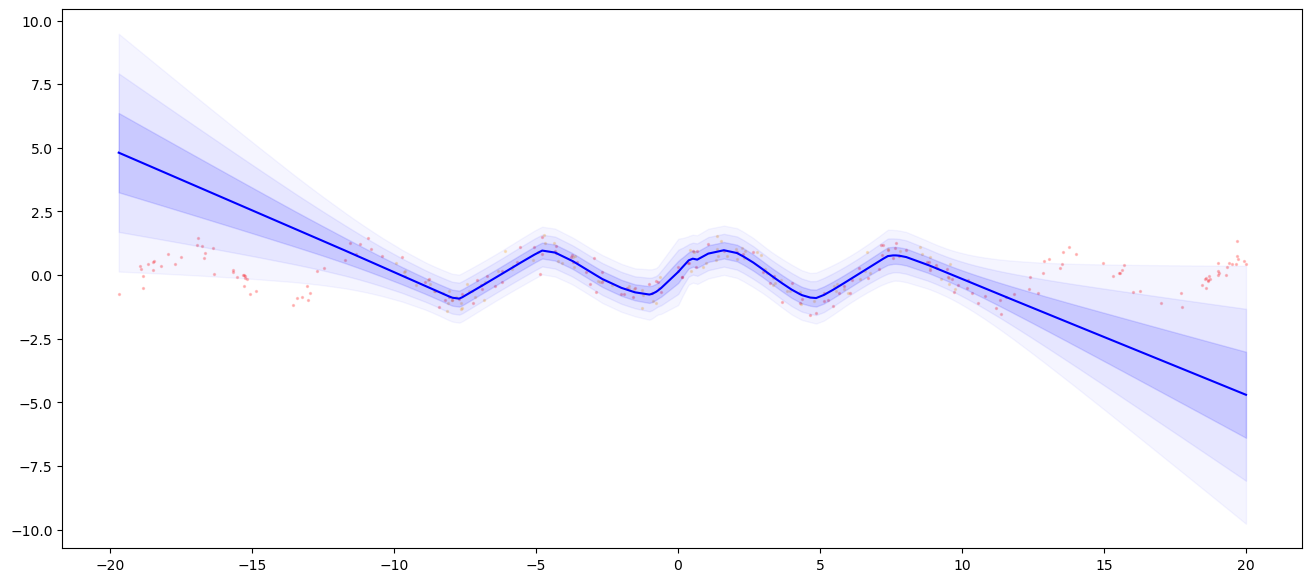

In [21]:
fig, ax = plt.subplots(figsize=(16, 7))
plt.scatter(x_test[test_sort].squeeze(), y_test[test_sort], color="red", s=2, alpha=0.2)
plt.scatter(x_train, y_train, color="orange", s=2, alpha=0.2)
plt.plot(x_test[test_sort], means, color="blue")
#plt.fill_between(x_test[test_sort].squeeze(), minimum.squeeze(), maximum.squeeze(), alpha=0.1, color="blue")
for c in range(1, 4):
    plt.fill_between(x_test[test_sort].squeeze(), (means - c * stds).squeeze(), (means + c * stds).squeeze(), alpha=(1.5/c) * 0.08, color="blue")

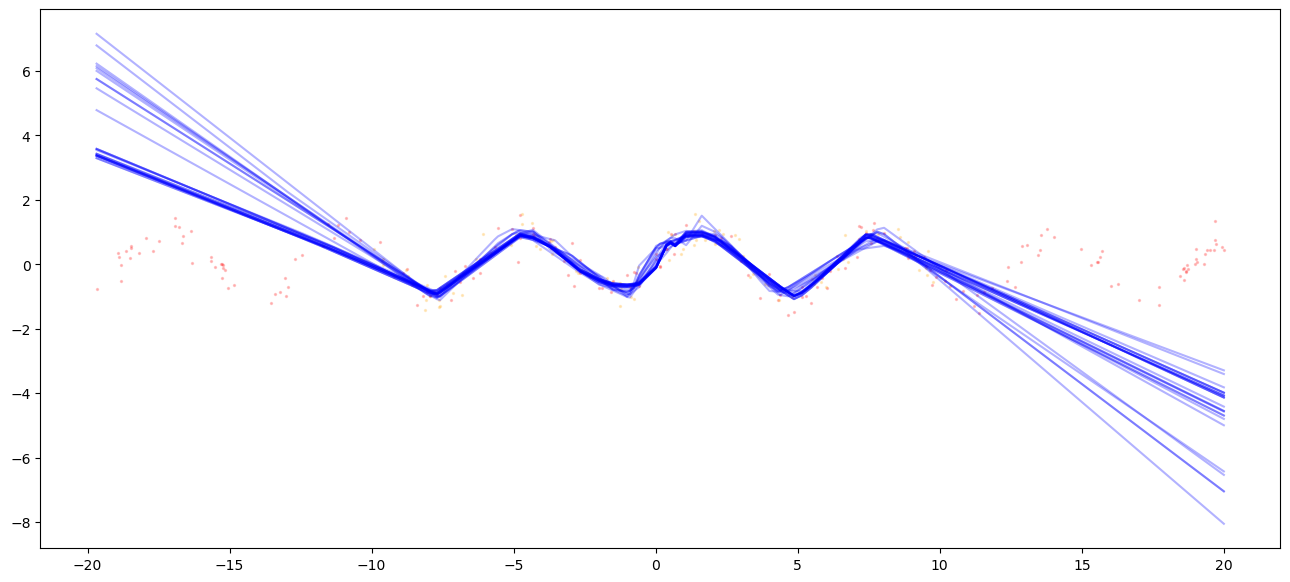

In [22]:
sampled_predictions = bnn.predict(x_test[test_sort].to(config["DEVICE"]), num_predictions=25, aggregate=False)
sampled_predictions = sampled_predictions.detach().cpu()
fig, ax = plt.subplots(figsize=(16, 7))
plt.scatter(x_test[test_sort].squeeze(), y_test[test_sort], color="red", s=2, alpha=0.2)
plt.scatter(x_train, y_train, color="orange", s=2, alpha=0.2)
for yhat in sampled_predictions:
    plt.plot(x_test[test_sort], yhat, color="blue", alpha=0.3)

In [23]:
if not os.path.exists(f"{BASE_DIR}/results"):
            os.mkdir(f"{BASE_DIR}/results")           
eval.eval(config, dataset_config, f"{BASE_DIR}", bnn=None, reruns=config.getint("RERUNS"), device=config["DEVICE"])

data samples:  (1000, 1000)
Settings:
DEVICE: cpu INFERENCE_TYPE: mcmc OBS_MODEL: homoskedastic PRIOR_LOC: 0.0 PRIOR_SCALE: 1.0 LIKELIHOOD_SCALE_LOC: 1.0 LIKELIHOOD_SCALE: 0.3 GUIDE_SCALE: 0.001 TRAIN_SIZE: 100
init mcmc


Warmup:   0%|          | 0/2 [00:00, ?it/s]/Home/siv31/tak011/.conda/envs/master/lib/python3.9/site-packages/pyro/poutine/subsample_messenger.py:63: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  result = torch.tensor(0.0, device=self.device)
Sample: 100%|██████████| 2/2 [00:00,  8.69it/s, step size=6.25e-02, acc. prob=0.803]


Loaded MCMC samples from ../tests/sanity_check/models/tyxe-test/checkpoint_1.pt
using device: cpu
====== evaluating profile tyxe-test - 1 ======
pred samples:  (1000, 1000)
Evaluating train...
Evaluating test...
Evaluating in_domain...
Evaluating out_domain...
Eval done in 0:00:05.882812


In [24]:
profiles= ["tyxe-test-mcmc"]

colors = ["green"]

names = [configs[p]["NAME"] for p in profiles]

In [25]:
from IPython.display import display, HTML
import json

train_stats = {}
for p in profiles:
    name = configs[p]["NAME"]
    with open(f"{BASE_DIR}/results/{name}/train_stats_1.json", "r") as f:
        train_stats[name] = json.load(f)

results = {}
for p in profiles:
    name = configs[p]["NAME"]
    with open(f"{BASE_DIR}/results/{name}/results_1.json", "r") as f:
        results[name] = json.load(f)

# Load posterior samples
posterior_samples = {}
for p in profiles:
    name = configs[p]["NAME"]
    # Load posterior samples
    train = np.load(f"{BASE_DIR}/results/{name}/posterior-samples/train_samples_1.npy")
    test = np.load(f"{BASE_DIR}/results/{name}/posterior-samples/test_samples_1.npy")
    test_in_domain = np.load(f"{BASE_DIR}/results/{name}/posterior-samples/test_in_domain_samples_1.npy")
    test_out_domain = np.load(f"{BASE_DIR}/results/{name}/posterior-samples/test_out_domain_samples_1.npy")

    posterior_samples[name] = {
        "train": train,
        "test": test,
        "test_in_domain": test_in_domain,
        "test_out_domain": test_out_domain
    }

FileNotFoundError: [Errno 2] No such file or directory: '../tests/sanity_check/results/tyxe-test-mcmc/train_stats_1.json'

In [ ]:
#Generate table for rmse
table = pd.DataFrame(columns=["Name", "Likelihood_std", "Train RMSE", "In domain RMSE", "Out domain RMSE"])
for p in profiles:
    name = configs[p]["NAME"]
    table = table.append({
        "Name": name,
        "Train RMSE": results[name]["train"]["error"]["rmse"],
        "In domain RMSE": results[name]["in_domain"]["error"]["rmse"],
        "Out domain RMSE": results[name]["out_domain"]["error"]["rmse"],
        "Likelihood_std": train_stats[name]["likelihood"]["mean"]
    }, ignore_index=True)

display(table)
print()

#Generate table for mae
table = pd.DataFrame(columns=["Name", "Likelihood_std", "Train MAE", "In domain MAE", "Out domain MAE"])
for p in profiles:
    name = configs[p]["NAME"]
    table = table.append({
        "Name": name,
        "Train MAE": results[name]["train"]["error"]["mae"],
        "In domain MAE": results[name]["in_domain"]["error"]["mae"],
        "Out domain MAE": results[name]["out_domain"]["error"]["mae"],
        "Likelihood_std": train_stats[name]["likelihood"]["mean"]
    }, ignore_index=True)

display(table)
print()

#Generate table for log likelihood
table = pd.DataFrame(columns=["Name", "Likelihood_std", "Train log likelihood", "In domain log likelihood", "Out domain log likelihood"])
for p in profiles:
    name = configs[p]["NAME"]
    table = table.append({
        "Name": name,
        "Train log likelihood": results[name]["train"]["error"]["loglikelihood"],
        "In domain log likelihood": results[name]["in_domain"]["error"]["loglikelihood"],
        "Out domain log likelihood": results[name]["out_domain"]["error"]["loglikelihood"],
        "Likelihood_std": train_stats[name]["likelihood"]["mean"]
    }, ignore_index=True)

display(table)

In [23]:
name1 = configs[profiles[0]]["NAME"]
data_samples = {
    "train_x": np.load(f"{BASE_DIR}/results/{name1}/data-samples/train_x.npy"),
    "test_in_domain_x": np.load(f"{BASE_DIR}/results/{name1}/data-samples/test_in_domain_x.npy"),
    "test_out_domain_x": np.load(f"{BASE_DIR}/results/{name1}/data-samples/test_out_domain_x.npy"),
    #"test_x": np.load(f"{BASE_DIR}/results/{name1}/data-samples/test_x.npy"),
    "train_dist_samples": np.load(f"{BASE_DIR}/results/{name1}/data-samples/train_dist_samples.npy"),
    "test_in_domain_dist_samples": np.load(f"{BASE_DIR}/results/{name1}/data-samples/test_in_domain_dist_samples.npy"),
    "test_out_domain_dist_samples": np.load(f"{BASE_DIR}/results/{name1}/data-samples/test_out_domain_dist_samples.npy"),
    #"test_dist_samples": np.load(f"{BASE_DIR}/results/{name1}/data-samples/test_dist_samples.npy"),
}

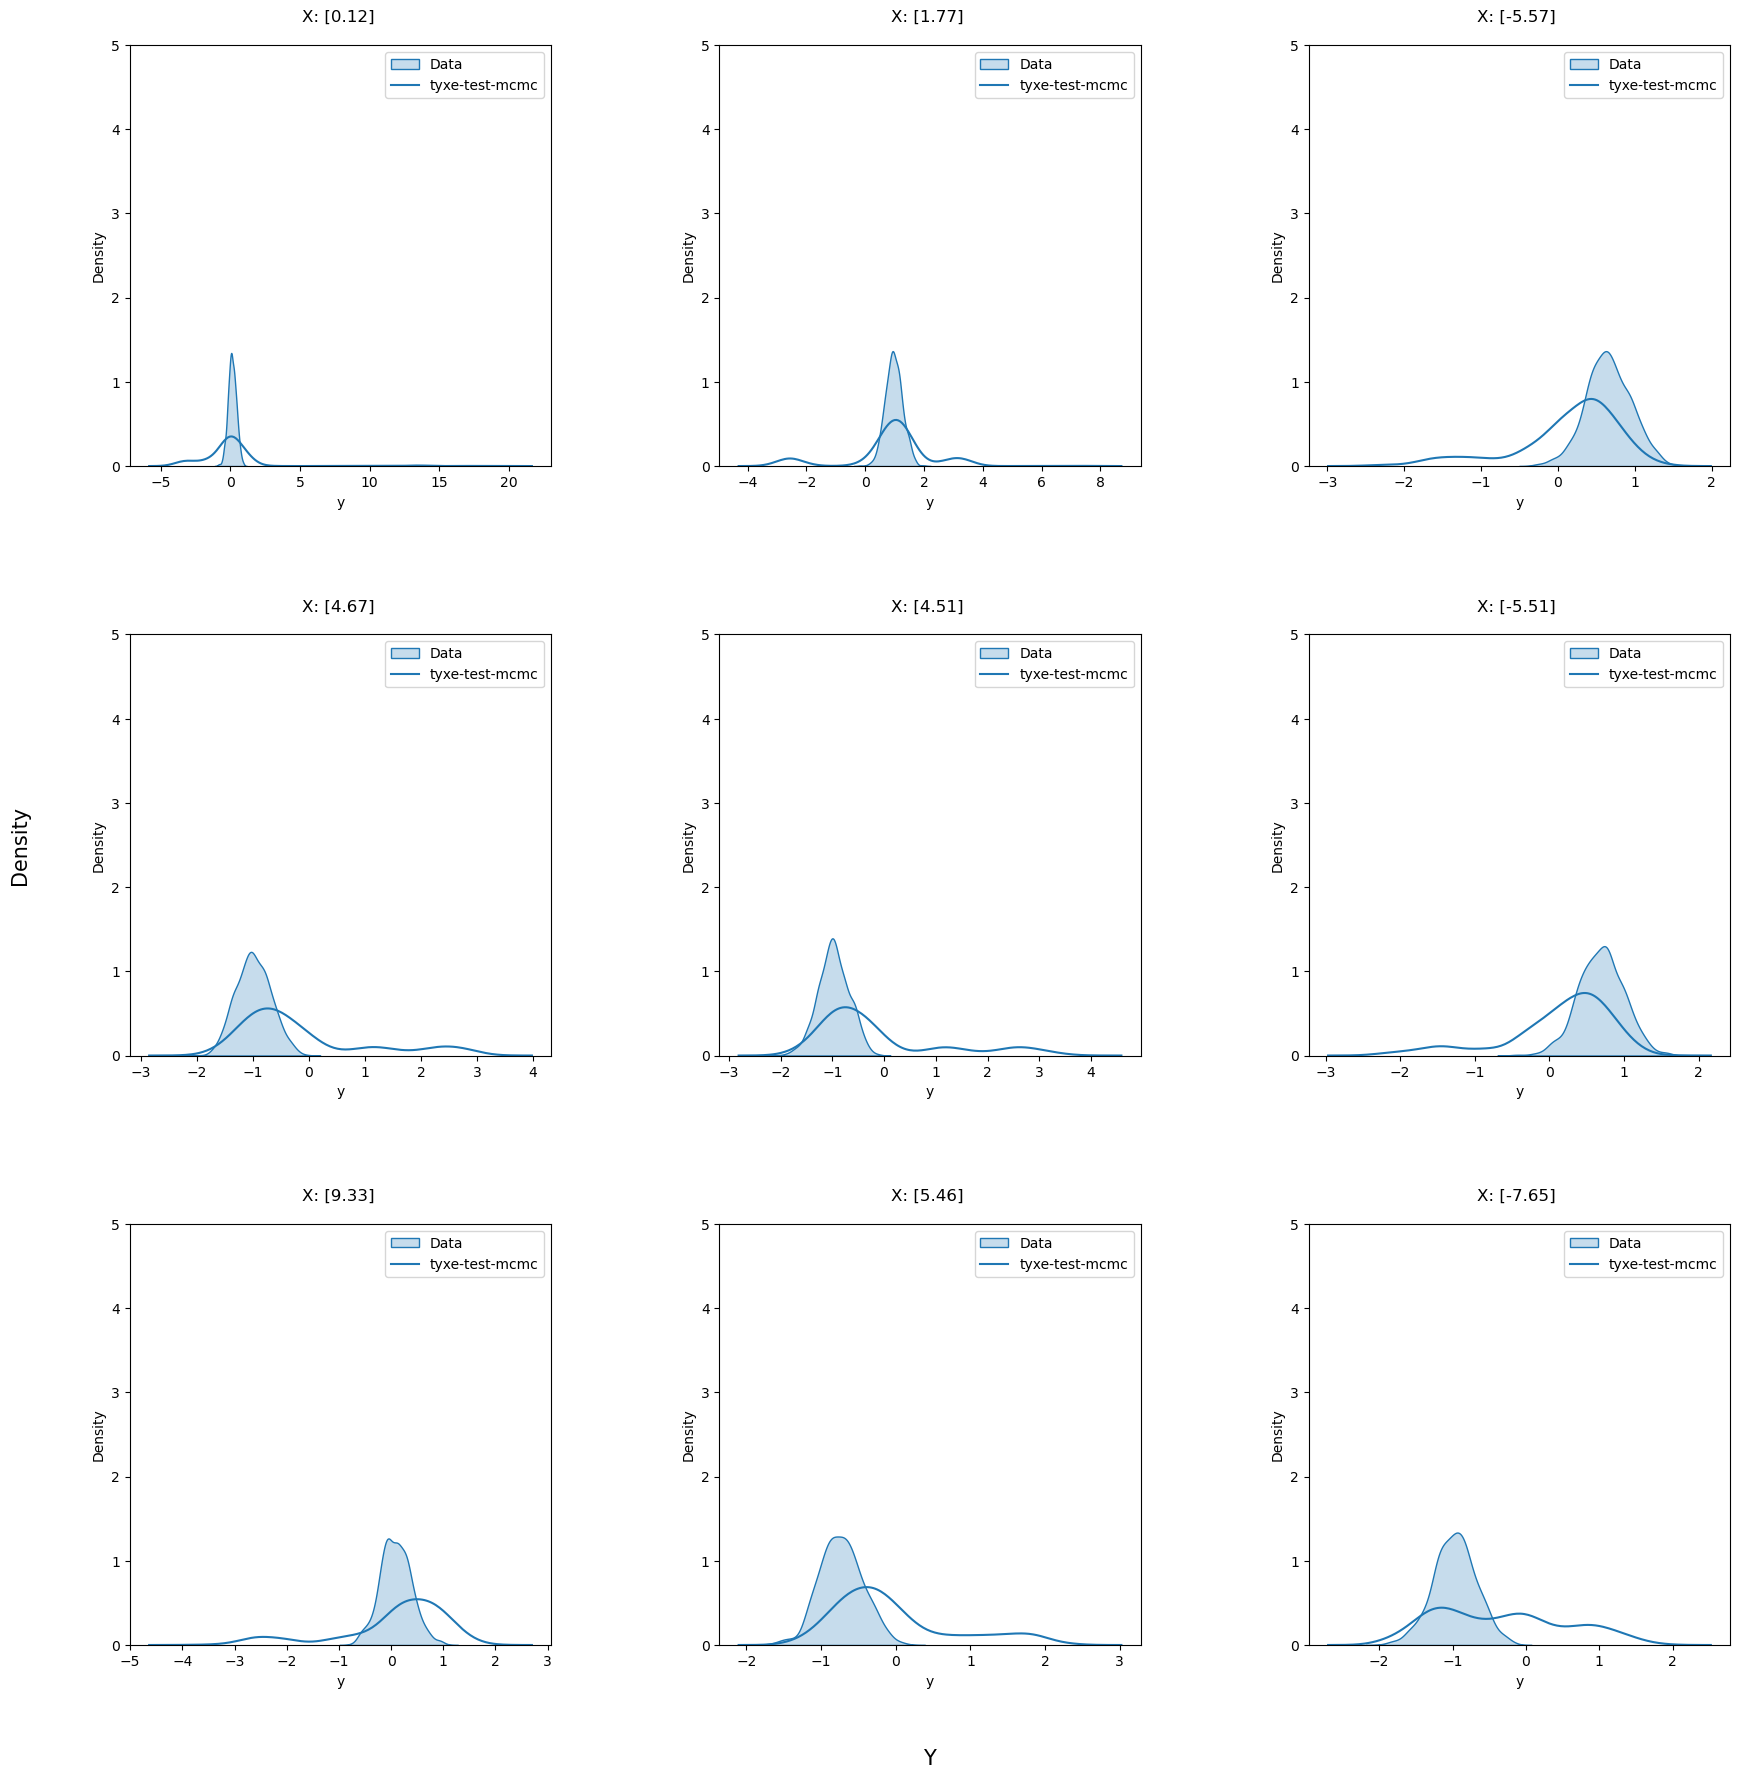

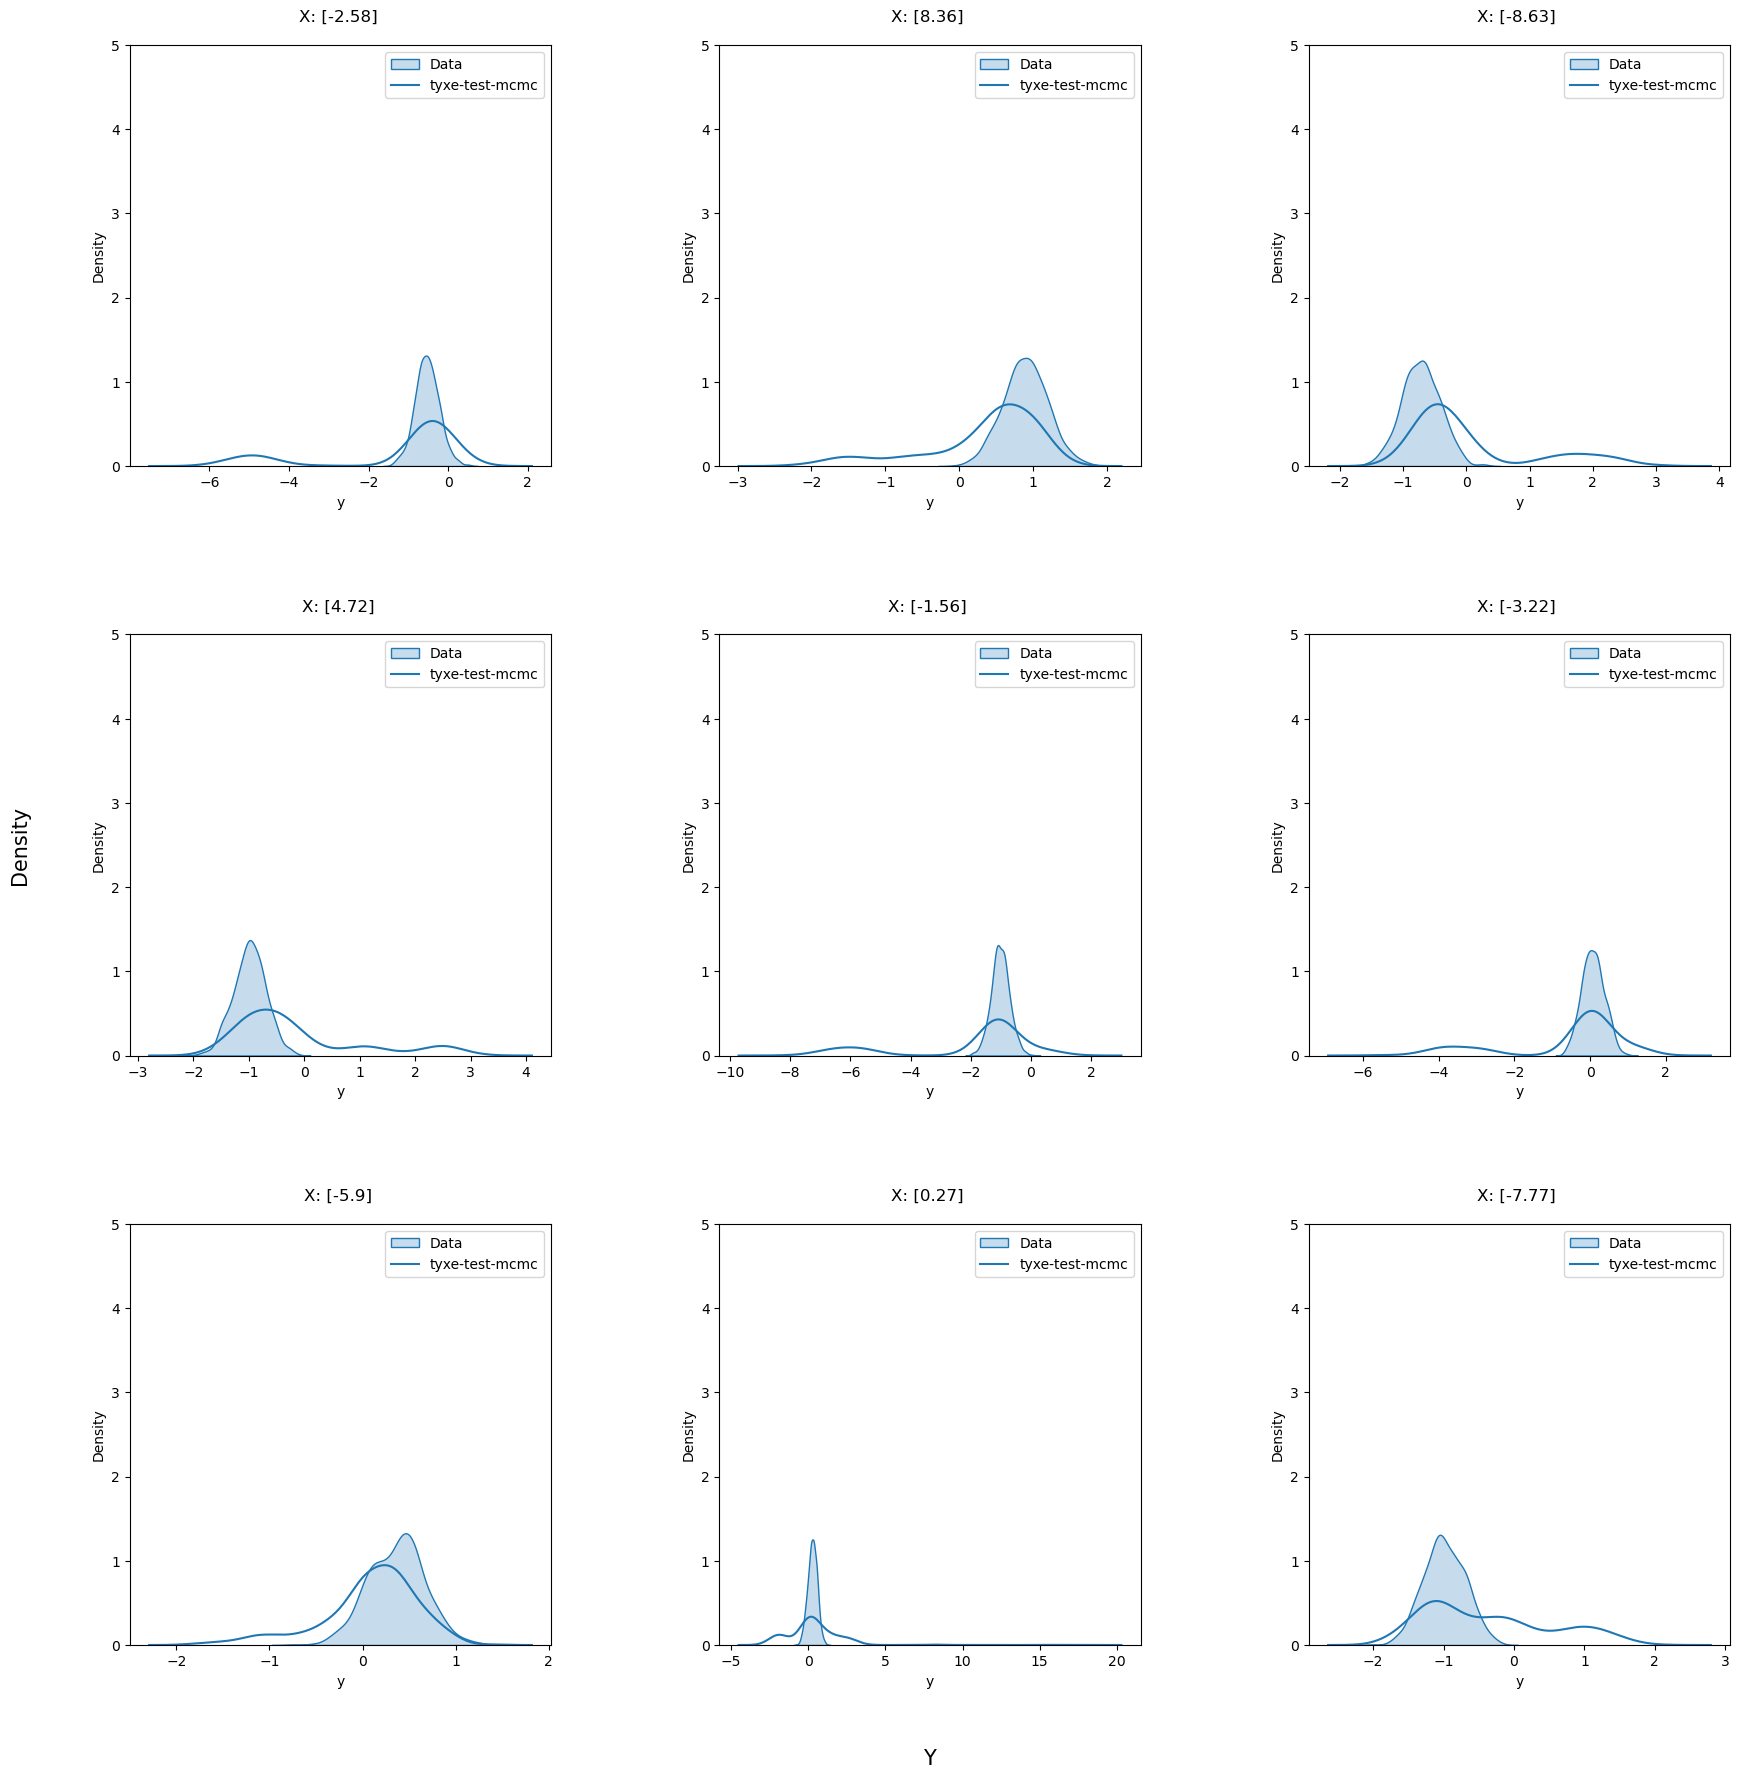

In [24]:

fig, axs = plt.subplots(3, 3, figsize=(20, 20))
axs = axs.flatten()
fig.tight_layout()
#fig.suptitle(title, fontsize=15)
fig.subplots_adjust(top=0.9, bottom=0.1, left=0.1, right=0.9, hspace=0.4, wspace=0.4)
fig.text(0.5, 0.04, 'Y', ha='center', fontsize=15)
fig.text(0.04, 0.5, 'Density', va='center', rotation='vertical', fontsize=15)

for i, ax in enumerate(axs):
    labels = [configs[p]["NAME"] for p in profiles]
    x_samp = data_samples["train_x"][i]
    train_samp = data_samples["train_dist_samples"][:, i]
    pred_train_samples = [posterior_samples[p]["train"][:, i] for p in profiles]
    plots.plot_comparisons(pred_train_samples, train_samp, labels=labels, x_sample=x_samp, ax=ax)   
    ax.set_ylim([0, 5])

plt.show()

fig, axs = plt.subplots(3, 3, figsize=(20, 20))
axs = axs.flatten()
fig.tight_layout()
#fig.suptitle(title, fontsize=15)
fig.subplots_adjust(top=0.9, bottom=0.1, left=0.1, right=0.9, hspace=0.4, wspace=0.4)
fig.text(0.5, 0.04, 'Y', ha='center', fontsize=15)
fig.text(0.04, 0.5, 'Density', va='center', rotation='vertical', fontsize=15)

for i, ax in enumerate(axs):
    labels = [configs[p]["NAME"] for p in profiles]
    x_samp = data_samples["test_in_domain_x"][i]
    train_samp = data_samples["test_in_domain_dist_samples"][:, i]
    pred_train_samples = [posterior_samples[p]["test_in_domain"][:, i] for p in profiles]
    plots.plot_comparisons(pred_train_samples, train_samp, labels=labels, x_sample=x_samp, ax=ax)   
    ax.set_ylim([0, 5])

plt.show()